In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import itertools
import cv2
from PIL import Image
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from keras_tuner import RandomSearch
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [58]:
model = tf.keras.models.load_model('../..//ML/Recognition/Model/FER_v2.keras')

In [3]:
label_mapping = {
    0: 0,  # Anger (CK+) to Angry (FER2013)
    1: 1,  # Disgust (CK+) to Disgust (FER2013)
    2: 2,  # Fear (CK+) to Fear (FER2013)
    3: 3,  # Happiness (CK+) to Happy (FER2013)
    4: 5,  # Sadness (CK+) to Sad (FER2013)
    5: 6,  # Surprise (CK+) to Surprise (FER2013)
    6: 4   # Neutral (CK+) to Neutral (FER2013)
}

In [4]:
evalute_df = pd.read_csv('../../Dataset/CK+/ckextended.csv')

In [5]:
def string_to_array(pixel_string):
    array = np.fromstring(pixel_string, sep=' ', dtype=np.float32)
    array = array.reshape(48,48)
    image = Image.fromarray(array)
    image = image.resize((64,64), Image.BILINEAR)
    return np.expand_dims(np.array(image), axis=-1)/ 255.0

In [6]:
evalute_df = evalute_df[evalute_df['emotion'] != 7]
evalute_df.loc[:, 'pixels'] = evalute_df['pixels'].apply(string_to_array)
evalute_df['emotion'] = evalute_df['emotion'].map(label_mapping)

In [16]:
evalute_df

,emotion,pixels,Usage
0,4,"[[[0.14117648], [0.14852941], [0.14705883], [0...",Training
1,4,"[[[0.34509805], [0.3107843], [0.20931372], [0....",Training
2,4,"[[[0.03529412], [0.018137256], [0.010784314], ...",Training
3,4,"[[[0.40784314], [0.4127451], [0.41862744], [0....",Training
4,4,"[[[0.26666668], [0.2764706], [0.275], [0.26274...",Training
...,...,...,...
915,6,"[[[0.34117648], [0.33872548], [0.34019607], [0...",PrivateTest
916,6,"[[[0.08235294], [0.089705884], [0.097058825], ...",PrivateTest
917,6,"[[[0.29803923], [0.20980392], [0.14362745], [0...",PrivateTest
918,6,"[[[0.44705883], [0.38088235], [0.2367647], [0....",PrivateTest


In [21]:
val_data = evalute_df[evalute_df['Usage']=='PrivateTest']
train_data = evalute_df[evalute_df['Usage']=='Training']
test_data = evalute_df[evalute_df['Usage']=='PublicTest']

In [22]:
test_data = test_data.drop('Usage', axis=1)
train_data = train_data.drop('Usage', axis=1)
val_data = val_data.drop('Usage', axis=1)

In [56]:
X_test = np.stack(test_data['pixels'].values)
y_test = pd.get_dummies(test_data['emotion'].values).astype(float)
X_train = np.stack(train_data['pixels'].values)
y_train = pd.get_dummies(train_data['emotion'].values).astype(float)
X_val = np.stack(val_data['pixels'].values)
y_val = pd.get_dummies(val_data['emotion'].values).astype(float)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

In [59]:
history = model.fit(X_train ,y_train ,epochs=90, validation_data=(X_val,y_val), callbacks=[early_stopping])

Epoch 1/90
23/23 [==============================] - 7s 210ms/step - loss: 0.6182 - accuracy: 0.8278 - val_loss: 0.5955 - val_accuracy: 0.8387
Epoch 2/90
23/23 [==============================] - 5s 213ms/step - loss: 0.4871 - accuracy: 0.8611 - val_loss: 0.5420 - val_accuracy: 0.8495
Epoch 3/90
23/23 [==============================] - 5s 201ms/step - loss: 0.4534 - accuracy: 0.8681 - val_loss: 0.4928 - val_accuracy: 0.8495
Epoch 4/90
23/23 [==============================] - 4s 184ms/step - loss: 0.4425 - accuracy: 0.8708 - val_loss: 0.4571 - val_accuracy: 0.8817
Epoch 5/90
23/23 [==============================] - 4s 177ms/step - loss: 0.3875 - accuracy: 0.8819 - val_loss: 0.4354 - val_accuracy: 0.8602
Epoch 6/90
23/23 [==============================] - 4s 176ms/step - loss: 0.3785 - accuracy: 0.8903 - val_loss: 0.4231 - val_accuracy: 0.8710
Epoch 7/90
23/23 [==============================] - 4s 161ms/step - loss: 0.3429 - accuracy: 0.8972 - val_loss: 0.4245 - val_accuracy: 0.8710
Epoch 

In [60]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

3/3 [==============================] - 0s 19ms/step - loss: 0.3718 - accuracy: 0.9213
Test Loss: 0.37179866433143616, Test Accuracy: 0.9213483333587646


In [73]:
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

# Predict classes
y_pred = model.predict(np.array(X_test))
y_pred_classes = np.argmax(y_pred, axis=1)

# Assuming your labels were categorical and one-hot encoded during training
# y_test_categorical = to_categorical(y_test)
y_test_classes = np.argmax(y_test, axis=1)

# Validate shapes
print(f"Shape of y_test_classes: {y_test_classes.shape}")
print(f"Shape of y_pred_classes: {y_pred_classes.shape}")

# Ensure both are 1D arrays of the same length
# assert y_test_classes.ndim == 1
# assert y_pred_classes.ndim == 1
# assert y_test_classes.shape[0] == y_pred_classes.shape[0]

# Now generate the classification report
print(classification_report(y_test_classes, y_pred_classes))


3/3 [==============================] - 0s 21ms/step


Shape of y_test_classes: (89,)
Shape of y_pred_classes: (89,)
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      0.83      0.91         6
           2       0.00      0.00      0.00         2
           3       0.88      1.00      0.93         7
           4       0.91      1.00      0.95        59
           5       0.00      0.00      0.00         3
           6       1.00      1.00      1.00         8

    accuracy                           0.92        89
   macro avg       0.68      0.65      0.66        89
weighted avg       0.87      0.92      0.89        89



d:\Program Files (x86)\Python\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Program Files (x86)\Python\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Program Files (x86)\Python\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


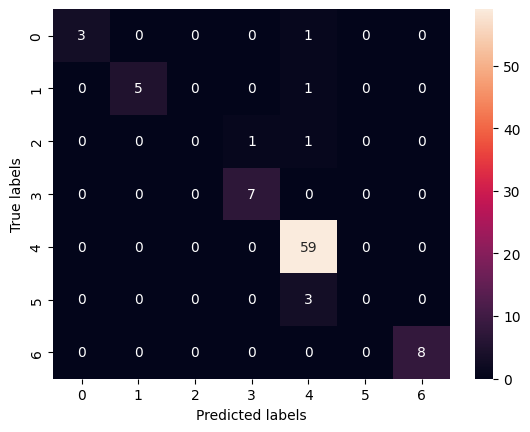

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [77]:
model.save('../Recognition/Model/FER_w_CK+_v1.keras')